# Домашнее задание 2. StarGAN

## Этап 1. Установка зависимостей, инициализация и загрузка данных

В этом разделе мы работаем с датасетом CelebA, содержащим изображения лиц с набором атрибутов. Целью задания является генерация новых изображений лиц с заданными характеристиками.

Download dataset from kaggle (default way using google drive doens't work)

In [1]:
# ! kaggle datasets download dayiyao/celeba-dataset

In [1]:
from munch import Munch
from celeba import CelebADataset
import torch
from lpips_pytorch import LPIPS
from torchvision import transforms
import gc
from tqdm.auto import trange
import wandb
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

from torch.backends import cudnn

import os
import time
import datetime

from core.loss import compute_d_loss, compute_g_loss
from core.utils import parse_images, vis_faces

/home/sudakovcom/Desktop/StarGAN/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
args = Munch()

# model arguments
args.img_size = 256
args.num_domains = 40
args.latent_dim = 16
args.hidden_dim = 512
args.style_dim = 64

# weight for objective functions
args.lambda_reg = 1
args.lambda_cyc = 1
args.lambda_sty = 1
args.lambda_ds = 1
args.ds_iter = 100000

# training arguments
args.randcrop_prob = 0.5
args.total_iters = 100000
args.resume_iter = 30000
args.batch_gpu = 4
args.batch_size = 8
args.lr = 1e-4
args.f_lr = 1e-6
args.beta1 = 0.0
args.beta2 = 0.99
args.weight_decay = 1e-4
args.num_outs_per_domain = 10

# misc
args.seed = 1
args.mode = 'train'

# directory for training
args.sample_dir = 'expr/samples'
args.checkpoint_dir = 'expr/checkpoints'


# step size
args.print_every = 100
args.sample_every = 100
args.save_every = 1000

In [3]:
## Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Transformations to be applied to each individual image sample
transform=transforms.Compose([
    transforms.Resize(args.img_size),
    transforms.CenterCrop(args.img_size),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])

invTrans = transforms.Compose([
    transforms.Normalize(mean = [ 0., 0., 0. ],
                          std = [ 1/0.229, 1/0.224, 1/0.225 ]),
    transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                          std = [ 1., 1., 1. ]),
])

# Load the dataset from file and apply transformations
dataset = CelebADataset(transform=transform)

args.num_domains = len(dataset.header)

# Number of workers for the dataloader
num_workers = 0 if device.type == 'cuda' else 2
# Whether to put fetched data tensors to pinned memory
pin_memory = True if device.type == 'cuda' else False

# dataloader for batched data loading
dataloader = torch.utils.data.DataLoader(dataset,
                                                batch_size=args.batch_size,
                                                num_workers=num_workers,
                                                pin_memory=pin_memory,
                                                shuffle=True)

domains = {index: value for index, value in enumerate(dataset.header)}

print(args)
cudnn.benchmark = True
torch.manual_seed(args.seed)

Munch({'img_size': 256, 'num_domains': 40, 'latent_dim': 16, 'hidden_dim': 512, 'style_dim': 64, 'lambda_reg': 1, 'lambda_cyc': 1, 'lambda_sty': 1, 'lambda_ds': 1, 'ds_iter': 100000, 'randcrop_prob': 0.5, 'total_iters': 100000, 'resume_iter': 30000, 'batch_gpu': 4, 'batch_size': 8, 'lr': 0.0001, 'f_lr': 1e-06, 'beta1': 0.0, 'beta2': 0.99, 'weight_decay': 0.0001, 'num_outs_per_domain': 10, 'seed': 1, 'mode': 'train', 'sample_dir': 'expr/samples', 'checkpoint_dir': 'expr/checkpoints', 'print_every': 100, 'sample_every': 100, 'save_every': 1000})


### Визуализация датасета

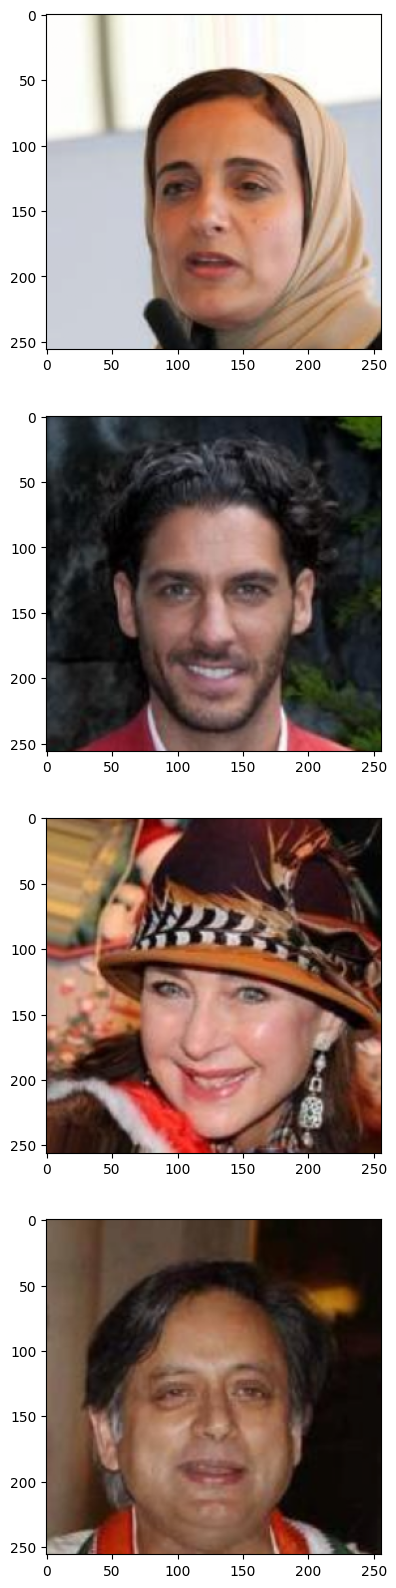

In [4]:
images_cnt = 4
plt.figure(figsize=(17,images_cnt*5))
for i, img_idx in enumerate(np.random.choice(range(len(dataset)), images_cnt)):
    img, target = dataset[img_idx]
    img = invTrans(img)
    # attributes dict for a given image. Contains 40 attributes
    attributes = {k:v for k,v in zip(dataset.header, target['attributes'].detach().cpu().numpy())}
    plt.subplot(images_cnt,1,i+1)
    plt.imshow(img.detach().cpu().numpy().transpose(1,2,0))

## Этап 2. Инициализация и обучение модели

В этом этапе необходимо реализовать и обучить модель StarGAN для генерации лиц с заданными атрибутами.

Вы можете выбрать одну из следующих моделей:
- [StarGANv1](https://arxiv.org/pdf/1711.09020.pdf) (**до 4 баллов**)
- [StarGANv2](https://arxiv.org/abs/1912.01865) (**до 7 баллов**)

### Инициализация

In [5]:
import core.utils as utils
import gc
import torch.nn as nn
from core.model import Generator, MappingNetwork, StyleEncoder, Discriminator


class StarGANv2(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.args = args
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        generator = Generator(args.img_size, args.style_dim)
        mapping_network = MappingNetwork(args.latent_dim, args.style_dim, args.num_domains)
        style_encoder = StyleEncoder(args.img_size, args.style_dim, args.num_domains)
        discriminator = Discriminator(args.img_size, args.num_domains)

        self.nets = Munch(generator=generator,
                    mapping_network=mapping_network,
                    style_encoder=style_encoder,
                    discriminator=discriminator)

        for name, module in self.nets.items():
            setattr(self, name, module)

        for name, network in self.named_children():
            network.apply(utils.he_init)

        self.to(self.device)

        self.optims = Munch()
        for net in self.nets.keys():
            self.optims[net] = torch.optim.Adam(
                params=self.nets[net].parameters(),
                lr=args.f_lr if net == 'mapping_network' else args.lr,
                betas=[args.beta1, args.beta2],
                weight_decay=args.weight_decay)

        if self.args.resume_iter > 0:
            self._load_checkpoint(step=self.args.resume_iter)

    def _save_checkpoint(self, step):
        torch.save({
            'generator': self.nets.generator.state_dict(),
            'mapping_network': self.nets.mapping_network.state_dict(),
            'style_encoder': self.nets.style_encoder.state_dict(),
            'discriminator': self.nets.discriminator.state_dict(),
            }, f'{self.args.checkpoint_dir}/nets-state-{step}.pt')
        
        torch.save({
            'generator': self.optims['generator'].state_dict(),
            'mapping_network': self.optims['mapping_network'].state_dict(),
            'style_encoder': self.optims['style_encoder'].state_dict(),
            'discriminator': self.optims['discriminator'].state_dict(),
            }, f'{self.args.checkpoint_dir}/optims-state-{step}.pt')

    def _load_checkpoint(self, step):

        checkpoint_net = torch.load(f'{self.args.checkpoint_dir}/nets-state-{step}.pt', weights_only=True)
        for name, module in self.nets.items():
            module.load_state_dict(checkpoint_net[name])

        checkpoint_optims = torch.load(f'{self.args.checkpoint_dir}/optims-state-{step}.pt', weights_only=True)
        for name, module in self.optims.items():
            module.load_state_dict(checkpoint_optims[name])

        del checkpoint_net, checkpoint_optims
        gc.collect(); torch.cuda.empty_cache()

    def _reset_grad(self):
        for optim in self.optims.values():
            optim.zero_grad()

In [6]:
solver = StarGANv2(args)

### Обучение

In [ ]:
wandb.login()
run = wandb.init(
    project='StarGANv2',
    name='start_train',
    config=args, id='lsjjo7wl', resume="must")

In [ ]:
args = solver.args
nets = solver.nets
optims = solver.optims

# remember the initial value of ds weight
initial_lambda_ds = args.lambda_ds

print('Start training...')
start_time = time.time()
for iteration in range(args.resume_iter, args.total_iters):

    x_real, x_dct = next(iter(dataloader))
    y_org = []
    for i in range(args.batch_size):
        y_org.append(np.random.choice(np.where(np.array(x_dct['attributes'][i]) == 1)[0]))
    y_org = torch.tensor(y_org).long()
    x_ref, _ = next(iter(dataloader))
    x_ref2, _ = next(iter(dataloader))
    y_trg = torch.tensor(np.random.choice(np.arange(args.num_domains), size=args.batch_size)).long()
    z_trg = torch.randn(args.batch_size, args.latent_dim)
    z_trg2 = torch.randn(args.batch_size, args.latent_dim)

    x_real = x_real.to(device)
    y_org = y_org.to(device)
    x_ref = x_ref.to(device)
    x_ref2 = x_ref2.to(device)
    y_trg = y_trg.to(device)
    z_trg = z_trg.to(device)
    z_trg2 = z_trg2.to(device)

    # train the discriminator
    solver._reset_grad()
    for step in range(args.batch_size//args.batch_gpu):
        d_loss, d_losses_latent = compute_d_loss(
            nets, args, 
            x_real[args.batch_gpu*step:args.batch_gpu*(step+1)], 
            y_org[args.batch_gpu*step:args.batch_gpu*(step+1)], 
            y_trg[args.batch_gpu*step:args.batch_gpu*(step+1)], 
            z_trg=z_trg[args.batch_gpu*step:args.batch_gpu*(step+1)])
        d_loss.backward()
    optims.discriminator.step()

    solver._reset_grad()
    for step in range(args.batch_size//args.batch_gpu):
        d_loss, d_losses_ref = compute_d_loss(
            nets, args, 
            x_real[args.batch_gpu*step:args.batch_gpu*(step+1)], 
            y_org[args.batch_gpu*step:args.batch_gpu*(step+1)], 
            y_trg[args.batch_gpu*step:args.batch_gpu*(step+1)], 
            x_ref=x_ref[args.batch_gpu*step:args.batch_gpu*(step+1)])
        d_loss.backward()
    optims.discriminator.step()

    # train the generator
    solver._reset_grad()
    for step in range(args.batch_size//args.batch_gpu):
        g_loss, g_losses_latent = compute_g_loss(
            nets, args, 
            x_real[args.batch_gpu*step:args.batch_gpu*(step+1)], 
            y_org[args.batch_gpu*step:args.batch_gpu*(step+1)], 
            y_trg[args.batch_gpu*step:args.batch_gpu*(step+1)], 
            z_trgs=[z_trg[args.batch_gpu*step:args.batch_gpu*(step+1)], z_trg2[args.batch_gpu*step:args.batch_gpu*(step+1)]])
        g_loss.backward()
    optims.generator.step()
    optims.mapping_network.step()
    optims.style_encoder.step()

    solver._reset_grad()
    for step in range(args.batch_size//args.batch_gpu):
        g_loss, g_losses_ref = compute_g_loss(
            nets, args, 
            x_real[args.batch_gpu*step:args.batch_gpu*(step+1)], 
            y_org[args.batch_gpu*step:args.batch_gpu*(step+1)], 
            y_trg[args.batch_gpu*step:args.batch_gpu*(step+1)], 
            x_refs=[x_ref[args.batch_gpu*step:args.batch_gpu*(step+1)], x_ref2[args.batch_gpu*step:args.batch_gpu*(step+1)]])
        g_loss.backward()
    optims.generator.step()

    # decay weight for diversity sensitive loss
    if args.lambda_ds > 0:
        args.lambda_ds -= (initial_lambda_ds / args.ds_iter)

    gc.collect(); torch.cuda.empty_cache()

    # print out log info
    if (iteration) % args.print_every == 0:
        elapsed = time.time() - start_time
        elapsed = str(datetime.timedelta(seconds=elapsed))[:-7]
        log = "Elapsed time [%s], Iteration [%i/%i], " % (elapsed, iteration+1, args.total_iters)
        all_losses = dict()
        for loss, prefix in zip([d_losses_latent, d_losses_ref, g_losses_latent, g_losses_ref],
                                ['D/latent_', 'D/ref_', 'G/latent_', 'G/ref_']):
            for key, value in loss.items():
                all_losses[prefix + key] = value
                wandb.log({f'{prefix + key}': value}, step=iteration)
        all_losses['G/lambda_ds'] = args.lambda_ds
        wandb.log({f'G/lambda_ds': args.lambda_ds}, step=iteration)
        log += ' '.join(['%s: [%.4f]' % (key, value) for key, value in all_losses.items()])
        print(log)

    # generate images for debugging
    if (iteration) % args.sample_every == 0:
        os.makedirs(args.sample_dir, exist_ok=True)
        
        with torch.no_grad():
            z = torch.randn(args.batch_size, args.latent_dim).to(device)
            y = torch.tensor(np.random.choice(np.arange(args.num_domains), size=args.batch_size)).to(device)
            style = nets.mapping_network(z, y)
            x_fake = nets.generator(x_real[range(args.batch_size),...], style)
            fig = vis_faces(parse_images(x_real, y, x_fake, domains, args.batch_size))
            fig.savefig(f'{args.sample_dir}/{iteration}.jpg')
            plt.close(fig)
            wandb.log({f'{args.sample_dir}/{iteration}.jpg': wandb.Image(f'{args.sample_dir}/{iteration}.jpg')}, step=iteration)

    # save model checkpoints
    if (iteration) % args.save_every == 0:
        solver._save_checkpoint(step=iteration)
        print('saved')

### Оценка модели

Для оценки качества сгенерированных изображений используется метрика LPIPS.

In [7]:
lpips = LPIPS()

/home/sudakovcom/Desktop/StarGAN/.conda/lib/python3.11/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/home/sudakovcom/Desktop/StarGAN/.conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [33]:
test_iters = 1000  # Количество итераций для тестирования модели
values = []
y_targets, styles = [], []
for i in trange(test_iters):
    x_real, _ = next(iter(dataloader))
    x_ref, _ = next(iter(dataloader))
    x_ref2, _ = next(iter(dataloader))
    
    batch_size = args.batch_gpu

    x_real = x_real[:batch_size]
    x_ref = x_ref[:batch_size]
    
    # Случайное задание целевого и исходного доменов для каждого изображения
    y_trg = torch.tensor(np.random.choice(np.arange(args.num_domains), size=batch_size))  # Целевой домен
    y_org = torch.tensor(np.random.choice(np.arange(args.num_domains), size=batch_size))  # Исходный домен
    
    # Перенос данных на выбранное устройство и приведение типов
    x_real, x_ref, x_ref2 = [x.to(device).float() for x in [x_real, x_ref, x_ref2]]
    y_trg, y_org = [x.to(device).long() for x in [y_trg, y_org]]
    
    # Генерация изображения с использованием вашей модели
    # raise NotImplementedError("Реализуйте генерацию изображения x_fake с использованием вашей модели")
    style = solver.nets.style_encoder(x_ref, y_trg)
    x_fake = solver.nets.generator(x_real, style)
    
    # Вычисление LPIPS между сгенерированным и реальным изображением
    values.append(lpips(x_fake.cpu(), x_real.cpu()).squeeze().item()/batch_size)
    y_targets += y_trg.tolist()
    styles += [tns.detach().cpu().numpy() for tns in style]

print("Среднее значение LPIPS:", np.mean(values))
assert np.mean(values) < 1.3

100%|██████████| 1000/1000 [02:41<00:00,  6.19it/s]

Среднее значение LPIPS: 0.42409077498316766


### Вывод результатов оценки

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.23976001..1.2266206].


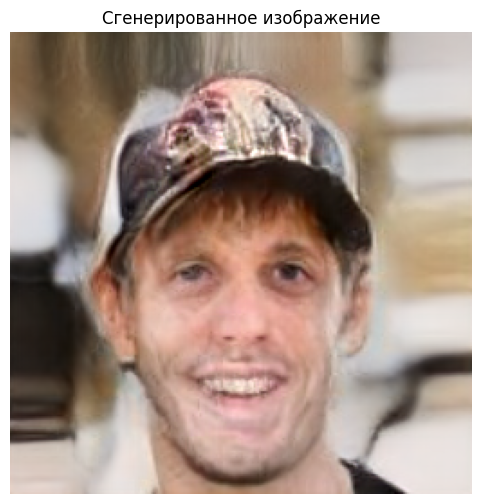

In [31]:
with torch.no_grad():
    z_trg = torch.randn((batch_size, args.latent_dim)).to(device)
    s_trg = solver.nets.mapping_network(z_trg, y_trg)
    # s_trg = nets.style_encoder(x_ref2, y_trg) 
    x_fake = solver.nets.generator(x_real, s_trg)
    x_fake = invTrans(x_fake)

plt.figure(figsize=(6, 6))
plt.imshow(x_fake[1].permute(1, 2, 0).detach().cpu().numpy())
plt.title("Сгенерированное изображение")
plt.axis('off')
plt.show()

## Этап 3. Дополнительный анализ

В данном разделе рекомендуется провести дополнительные эксперименты и анализ:
- **Анализ латентного пространства**. *(2 балла)*
- **Текстовое ревью решения**: опишите, какие изменения можно внести для улучшения модели, и обоснуйте их. *(1 балл)*

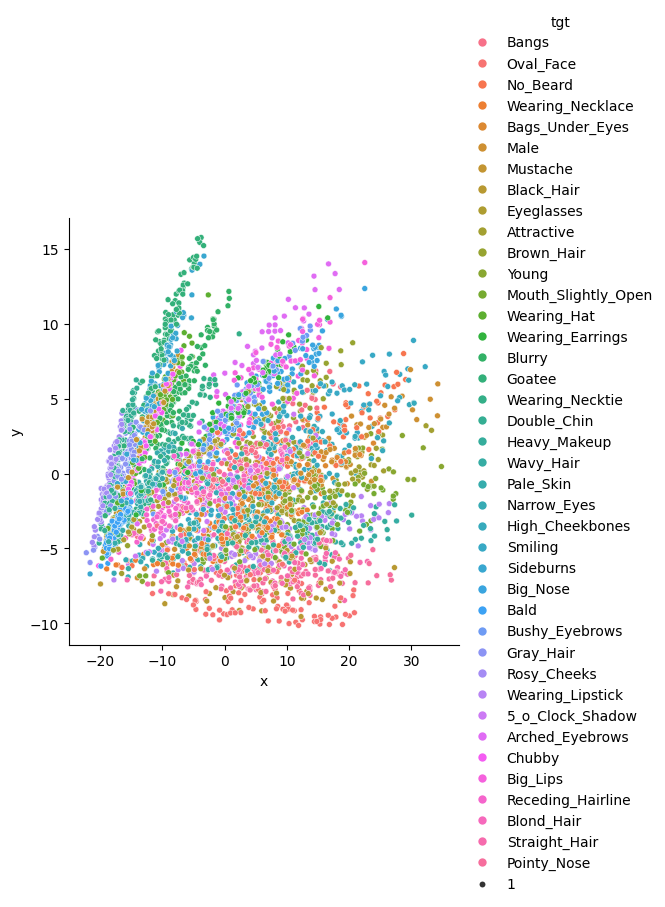

In [43]:
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA

y_targets = np.array(y_targets)
styles = np.array(styles)

styles_2d = PCA(n_components=2).fit_transform(styles)

targets = [dataset.header[idx] for idx in y_targets] 

data = pd.DataFrame(data={"x": styles_2d[:, 0], "y": styles_2d[:, 1], "tgt": targets})
sns.relplot(data=data, x="x", y="y", hue="tgt", size=1)

We see, that using style vectors, peoples can be good classified. That means that latents encoder learns style-relevant features

To improve the solution, it would be useful to sample pictures with rare attributes more frequent, according to it's quantity in train dataset.

Link to wandb logs: https://wandb.ai/sudakov/StarGANv2/runs/lsjjo7wl?nw=nwuserilyasudakov